In [1]:
# CELL 1: Install Necessary Packages
# ----------------------------------
# It's good practice to ensure all required packages are installed.
# CatBoost is installed separately for clarity.
!pip install pandas scikit-learn matplotlib seaborn --quiet
!pip install catboost --quiet
print("Required packages checked/installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00
Required packages checked/installed.


In [2]:
# CELL 2: Import Libraries
# ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Used if target is categorical and non-numeric
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from google.colab import files # For uploading files in Colab

print("Libraries imported.")

Libraries imported.


In [3]:
# CELL 3: Load the Dataset
# ------------------------
# This cell will prompt you to upload your CSV file.

print("Please upload your weather data CSV file.")
uploaded = files.upload()

# --- USER CONFIGURATION: File Name ---
# Verify this is the exact name of your uploaded CSV file.
csv_file_name = 'weather_data_output.csv' # Example: 'weather_data_output.csv'
# --- END USER CONFIGURATION ---

if csv_file_name in uploaded:
    print(f"\nSuccessfully uploaded '{csv_file_name}'. Processing...")
    try:
        # Attempt to read the CSV, parsing the timestamp column
        # If 'timestamp' column is purely numeric UNIX timestamps, parse_dates might not be needed here
        # and it's better to convert using pd.to_datetime(df['timestamp'], unit='s') later if needed.
        # The notebook has 'time' as the human-readable date string.
        df = pd.read_csv(csv_file_name)
        print("\nDataFrame loaded successfully. First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    except Exception as e:
        print(f"Error loading or parsing CSV '{csv_file_name}': {e}")
        df = pd.DataFrame() # Create an empty DataFrame on error
else:
    print(f"\nERROR: File '{csv_file_name}' not found in uploaded files. Please ensure the name matches.")
    df = pd.DataFrame() # Create an empty DataFrame if file not found

Please upload your weather data CSV file.


Saving weather_data_output.csv to weather_data_output.csv

Successfully uploaded 'weather_data_output.csv'. Processing...

DataFrame loaded successfully. First 5 rows:
    timestamp                 time  temp_C  pressure_hPa  humidity  \
0  1717156800  2024-06-01T00:00:00   13.92          1029        72   
1  1717160400  2024-06-01T01:00:00   13.40          1029        72   
2  1717164000  2024-06-01T02:00:00   13.09          1029        73   
3  1717167600  2024-06-01T03:00:00   13.05          1029        70   
4  1717171200  2024-06-01T04:00:00   13.93          1029        70   

   temp_min_C  temp_max_C  wind_m_s  wind_deg  clouds_percent  
0       12.64       14.84      4.63       210               3  
1       11.34       14.84      3.60       210               2  
2       10.78       14.84      3.09       210               1  
3       10.42       15.07      2.57       220              20  
4       10.64       15.99      4.63       210             100  

DataFrame Info:
<class 'pa

In [4]:
# CELL 4: Configuration for Preprocessing
# ---------------------------------------
# This cell centralizes key column names you might need to adjust.

# --- USER CONFIGURATION: Date Column for Feature Extraction ---
# This is the human-readable date/time column you want to extract features from (year, month, day, etc.)
# Your notebook used 'time'.
date_column_to_process = 'time'
# --- END USER CONFIGURATION ---


# --- CRITICAL USER CONFIGURATION: Target Variable ---
# What do you want to predict? For weather prediction, this is likely 'temp_C' or another weather parameter.
# The original notebook defaulted to the *last column after processing*, which became 'dayofweek'.
# Predicting 'dayofweek' is likely NOT your goal for weather forecasting.
#
# **ACTION REQUIRED**: Change 'target_column_name' to your actual target (e.g., 'temp_C').
# If you use a continuous variable like 'temp_C', the model will automatically become a Regressor.
target_column_name = 'temp_C' # <<<<<<<<<<<< EXAMPLE: CHANGE THIS TO YOUR ACTUAL TARGET WEATHER PARAMETER
# --- END USER CONFIGURATION ---

print(f"Configuration: Date column for feature extraction: '{date_column_to_process}'")
print(f"Configuration: Target variable for prediction: '{target_column_name}'")

Configuration: Date column for feature extraction: 'time'
Configuration: Target variable for prediction: 'temp_C'


In [5]:
# CELL 5: Preprocessing and Feature Engineering
# ---------------------------------------------

if not df.empty:
    # 1. Date Feature Extraction
    if date_column_to_process in df.columns:
        print(f"\nProcessing date column: '{date_column_to_process}'...")
        try:
            # Convert to datetime if not already
            if not pd.api.types.is_datetime64_any_dtype(df[date_column_to_process]):
                df[date_column_to_process] = pd.to_datetime(df[date_column_to_process])

            # Extract date features
            df['year'] = df[date_column_to_process].dt.year
            df['month'] = df[date_column_to_process].dt.month
            df['day'] = df[date_column_to_process].dt.day
            df['hour'] = df[date_column_to_process].dt.hour # Added hour, often useful
            df['dayofweek'] = df[date_column_to_process].dt.dayofweek
            df['dayofyear'] = df[date_column_to_process].dt.dayofyear # Added day of year

            # Drop the original date string column after extraction
            df = df.drop(columns=[date_column_to_process])
            print(f"Extracted features from '{date_column_to_process}' and dropped the original column.")
        except Exception as e:
            print(f"Could not process date column '{date_column_to_process}': {e}. It will be kept as is or dropped if not numeric.")
    else:
        print(f"Warning: Date column '{date_column_to_process}' not found. Skipping date feature extraction.")

    # 2. Verify Target Column and Handle NaNs in Target
    if target_column_name not in df.columns:
        print(f"\nERROR: Specified target column '{target_column_name}' not found in DataFrame.")
        print(f"Available columns: {df.columns.tolist()}")
        # Potentially exit or allow user to re-specify
    else:
        if df[target_column_name].isnull().any():
            print(f"\nTarget column '{target_column_name}' has {df[target_column_name].isnull().sum()} NaN values. Dropping these rows.")
            df.dropna(subset=[target_column_name], inplace=True)

        if df.empty:
            print(f"DataFrame became empty after dropping NaNs from target column '{target_column_name}'. Cannot proceed.")

if not df.empty and target_column_name in df.columns:
    # 3. Define Features (X) and Target (y)
    X = df.drop(columns=[target_column_name])
    y = df[target_column_name]
    print(f"\nFeatures (X) and target (y) defined. X shape: {X.shape}, y shape: {y.shape}")

    # 4. Identify Categorical Features in X
    # We will also convert any remaining 'object' type columns to string for CatBoost
    categorical_features_indices = []
    for i, col in enumerate(X.columns):
        if X[col].dtype == 'object':
            X[col] = X[col].astype(str).fillna('NA_placeholder') # Convert object to string and fill NA
            categorical_features_indices.append(i)
        elif pd.api.types.is_categorical_dtype(X[col]):
            X[col] = X[col].astype(str).fillna('NA_placeholder') # Ensure categoricals are string type for CatBoost
            categorical_features_indices.append(i)

    if categorical_features_indices:
        print(f"\nIdentified/converted categorical features at column indices: {categorical_features_indices}")
        print(f"Categorical column names: {X.columns[categorical_features_indices].tolist()}")
    else:
        print("\nNo object or categorical dtypes found to mark as categorical features automatically.")

    # 5. Handle NaNs in Numeric Features (fill with mean)
    for col in X.columns:
        if X[col].isnull().any():
            if pd.api.types.is_numeric_dtype(X[col]):
                mean_val = X[col].mean()
                X[col].fillna(mean_val, inplace=True)
                print(f"Filled NaNs in numeric column '{col}' with its mean ({mean_val:.2f}).")
            elif col not in X.columns[categorical_features_indices].tolist(): # If not already handled as categorical
                X[col].fillna('NA_placeholder', inplace=True) # Fill other NaNs as placeholder string
                print(f"Filled NaNs in non-numeric/non-identified-categorical column '{col}' with 'NA_placeholder'.")
                # If this column should be treated as categorical, add its index to categorical_features_indices
                # For simplicity, this step is basic. More complex NaN strategies might be needed.

    print("\nPreprocessing completed.")
    print("\nFinal X dtypes:\n", X.dtypes)
    print("\nFinal y dtype:", y.dtype)

else:
    print("\nSkipping further processing as DataFrame is empty or target column is missing.")


Processing date column: 'time'...
Extracted features from 'time' and dropped the original column.

Features (X) and target (y) defined. X shape: (1512, 14), y shape: (1512,)

No object or categorical dtypes found to mark as categorical features automatically.

Preprocessing completed.

Final X dtypes:
 timestamp           int64
pressure_hPa        int64
humidity            int64
temp_min_C        float64
temp_max_C        float64
wind_m_s          float64
wind_deg            int64
clouds_percent      int64
year                int32
month               int32
day                 int32
hour                int32
dayofweek           int32
dayofyear           int32
dtype: object

Final y dtype: float64


<ipython-input-5-ac57535f5a4c>:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(X[col]):


In [6]:
# CELL 6: Split Data into Training and Testing sets
# -------------------------------------------------
if 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nData split into training and testing sets:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    if X_train.empty or y_train.empty:
        print("ERROR: Training data is empty after split. Check dataset size or preprocessing steps.")
else:
    print("\nCannot split data: Features (X) or target (y) not available or empty.")


Data split into training and testing sets:
X_train shape: (1209, 14), y_train shape: (1209,)
X_test shape: (303, 14), y_test shape: (303,)


In [7]:
# CELL 7: Initialize, Train CatBoost Model, and Save Model
# --------------------------------------------------------
model = None # Initialize model variable

if 'X_train' in locals() and not X_train.empty:
    # Determine if the task is classification or regression based on the target variable y_train
    is_classification_task = False
    label_encoder = None # For potential label encoding if target is string categorical

    if pd.api.types.is_numeric_dtype(y_train):
        # If numeric, check number of unique values to guess if it's regression or classification
        # This threshold is heuristic. For true classification, ensure target is integer.
        if y_train.nunique() < 20 and pd.api.types.is_integer_dtype(y_train): # Heuristic for few unique integer values
             is_classification_task = True
             print(f"\nTarget variable '{target_column_name}' appears to be numeric but with few unique values ({y_train.nunique()}). Treating as CLASSIFICATION.")
        else:
             is_classification_task = False
             print(f"\nTarget variable '{target_column_name}' is numeric. Treating as REGRESSION.")
    else: # Object or other non-numeric types are treated as classification
        is_classification_task = True
        print(f"\nTarget variable '{target_column_name}' is not numeric. Treating as CLASSIFICATION.")
        # For CatBoost, string labels are fine for classification, but if you need integer labels for other reasons:
        # label_encoder = LabelEncoder()
        # y_train = label_encoder.fit_transform(y_train)
        # y_test = label_encoder.transform(y_test)
        # print(f"Applied LabelEncoder to target. Classes: {label_encoder.classes_}")


    # Initialize CatBoost model
    if is_classification_task:
        model = CatBoostClassifier(
            iterations=500, # Increased iterations, adjust as needed
            learning_rate=0.05,
            depth=6,
            loss_function='MultiClass' if y_train.nunique() > 2 else 'Logloss', # Or 'MultiClass'
            eval_metric='Accuracy', # Or 'F1', 'AUC' etc.
            cat_features=categorical_features_indices,
            random_seed=42,
            verbose=100, # Prints progress every 100 iterations
            early_stopping_rounds=50 # Stops if no improvement after 50 rounds on eval set
        )
        print("\nInitialized CatBoostClassifier.")
    else: # Regression
        model = CatBoostRegressor(
            iterations=500, # Increased iterations
            learning_rate=0.05,
            depth=6,
            loss_function='RMSE',
            eval_metric='RMSE',
            cat_features=categorical_features_indices,
            random_seed=42,
            verbose=100,
            early_stopping_rounds=50
        )
        print("\nInitialized CatBoostRegressor.")

    # Create training and testing pools
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

    # Train the model
    print("\nStarting model training...")
    model.fit(train_pool, eval_set=eval_pool)

    # Save the trained model
    model_filename = 'catboost_trained_model.cbm'
    model.save_model(model_filename)
    print(f"\n--- Model training complete. Model saved as '{model_filename}' ---")

else:
    print("\nSkipping model training: Training data not available.")


Target variable 'temp_C' is numeric. Treating as REGRESSION.

Initialized CatBoostRegressor.

Starting model training...
0:	learn: 3.9427717	test: 4.1420017	best: 4.1420017 (0)	total: 49.3ms	remaining: 24.6s
100:	learn: 0.3055405	test: 0.3281418	best: 0.3281418 (100)	total: 218ms	remaining: 863ms
200:	learn: 0.2451900	test: 0.3007174	best: 0.3007174 (200)	total: 386ms	remaining: 573ms
300:	learn: 0.2020682	test: 0.2889274	best: 0.2887357 (297)	total: 668ms	remaining: 441ms
400:	learn: 0.1734674	test: 0.2829012	best: 0.2823061 (391)	total: 1.06s	remaining: 263ms
499:	learn: 0.1547425	test: 0.2780068	best: 0.2780068 (499)	total: 1.63s	remaining: 0us

bestTest = 0.2780067919
bestIteration = 499


--- Model training complete. Model saved as 'catboost_trained_model.cbm' ---



Making predictions on the test set...

Model Evaluation (Regressor):
Mean Squared Error (MSE): 0.0773
Root Mean Squared Error (RMSE): 0.2780
R-squared (R2 Score): 0.9959


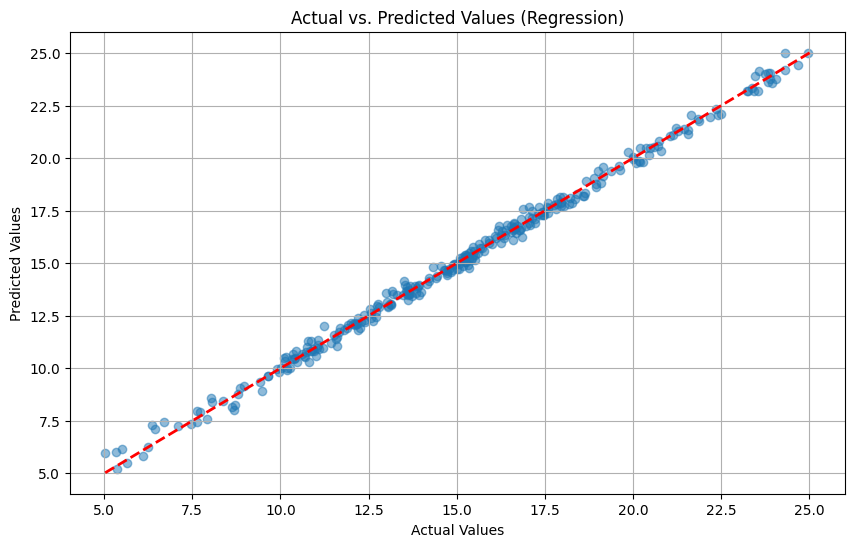

In [8]:
# CELL 8: Evaluate the Model
# --------------------------
if model and 'X_test' in locals() and not X_test.empty:
    print("\nMaking predictions on the test set...")
    predictions = model.predict(X_test)

    if is_classification_task: # From CELL 7
        # If predictions are probability arrays for multiclass, take argmax if needed
        # CatBoostClassifier.predict usually gives class labels directly
        # If label_encoder was used:
        # y_test_original_labels = label_encoder.inverse_transform(y_test)
        # predictions_original_labels = label_encoder.inverse_transform(predictions)
        # accuracy = accuracy_score(y_test_original_labels, predictions_original_labels)
        # report = classification_report(y_test_original_labels, predictions_original_labels, zero_division=0)

        accuracy = accuracy_score(y_test, predictions) # Use if no label encoder or labels are already numeric
        report = classification_report(y_test, predictions, zero_division=0)

        print(f"\nModel Evaluation (Classifier):")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", report)
    else: # Regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        print(f"\nModel Evaluation (Regressor):")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R-squared (R2 Score): {r2:.4f}")

        # Optional: Plot predictions vs actuals for regression
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, predictions, alpha=0.5)
        plt.plot([min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())],
                 [min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())],
                 color='red', linestyle='--', lw=2)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs. Predicted Values (Regression)")
        plt.grid(True)
        plt.show()

else:
    print("\nSkipping model evaluation: Model not trained or test data not available.")


Feature Importances:
        Feature Id  Importances
0       temp_max_C    52.568413
1       temp_min_C    39.453565
2            month     1.083334
3        timestamp     1.057353
4             hour     1.025023
5         wind_m_s     0.947340
6             year     0.775631
7   clouds_percent     0.655981
8        dayofyear     0.603844
9     pressure_hPa     0.455017
10        humidity     0.386162
11        wind_deg     0.353214
12             day     0.319775
13       dayofweek     0.315347


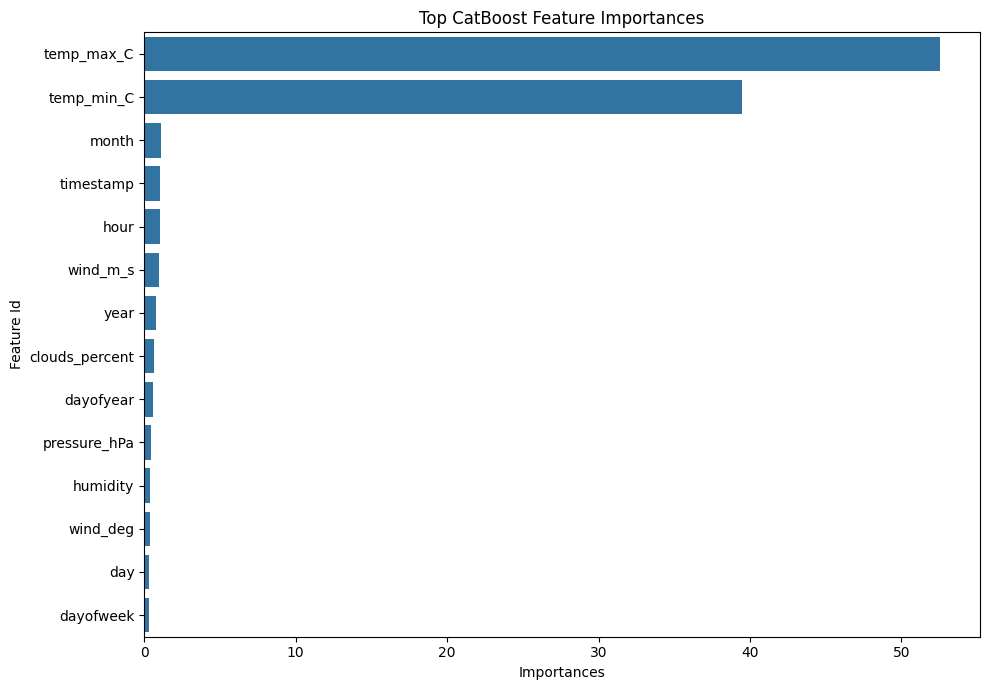


---
**Final Review & Customization Notes:**

1.  **Uploaded File**: Ensure `csv_file_name = 'weather_data_output.csv'` (in CELL 3) matches your uploaded file.
2.  **Date Column for Features**: Check `date_column_to_process = 'time'` (in CELL 4). This column is used to generate 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear'.
3.  **TARGET VARIABLE**: This is the most crucial setting. The script is currently set to predict `target_column_name = 'temp_C'` (in CELL 4).
    * **FOR WEATHER PREDICTION, YOU LIKELY NEED TO CHANGE THIS** (e.g., to 'temp_C', 'pressure_hPa', etc.).
    * The model type (Classifier or Regressor) will be chosen automatically based on this target.
4.  **Categorical Features**: The script attempts to auto-detect categorical features based on 'object' or 'category' dtype (CELL 5). Review if this correctly identifies all your non-numeric features that should be treated as categories. Numerical features that are actually categorical (e.g., an ID like `0, 1, 2`

In [9]:
# CELL 9: Feature Importances and Final Notes
# --------------------------------------------
if model:
    print("\nFeature Importances:")
    try:
        feature_importances = model.get_feature_importance(prettified=True)
        print(feature_importances)

        # Plot feature importances
        if not feature_importances.empty:
            plt.figure(figsize=(10, max(6, len(feature_importances) // 2))) # Adjust height based on num features
            sns.barplot(x="Importances", y="Feature Id", data=feature_importances.head(20)) # Display top 20
            plt.title('Top CatBoost Feature Importances')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Could not retrieve or plot feature importances: {e}")
else:
    print("\nSkipping feature importances: Model not trained.")

print(f"""
---
**Final Review & Customization Notes:**

1.  **Uploaded File**: Ensure `csv_file_name = '{csv_file_name}'` (in CELL 3) matches your uploaded file.
2.  **Date Column for Features**: Check `date_column_to_process = '{date_column_to_process}'` (in CELL 4). This column is used to generate 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear'.
3.  **TARGET VARIABLE**: This is the most crucial setting. The script is currently set to predict `target_column_name = '{target_column_name}'` (in CELL 4).
    * **FOR WEATHER PREDICTION, YOU LIKELY NEED TO CHANGE THIS** (e.g., to 'temp_C', 'pressure_hPa', etc.).
    * The model type (Classifier or Regressor) will be chosen automatically based on this target.
4.  **Categorical Features**: The script attempts to auto-detect categorical features based on 'object' or 'category' dtype (CELL 5). Review if this correctly identifies all your non-numeric features that should be treated as categories. Numerical features that are actually categorical (e.g., an ID like `0, 1, 2` representing different weather stations) would need to be manually added to `categorical_features_indices` or converted to string type beforehand.
5.  **Model Parameters**: `iterations`, `learning_rate`, `depth`, `early_stopping_rounds` in CatBoost (CELL 7) are starting points. You may need to tune these for better performance.
6.  **Lag Features for Time Series Forecasting**: This notebook performs a standard tabular data prediction. If your goal is multi-step time-series forecasting (e.g., predict temp for next 48 hours using past temperatures as lags), the feature engineering for creating those lag features (like `temp_lag1`, `temp_lag2`, ... `temp_lag48` and `temp_t+1`, ... `temp_t+48` from your previous script) is **NOT** included here. This notebook uses date components (year, month, hour etc.) and other available columns as features. If you need time-series lag features, you would need to incorporate that specific feature engineering logic into CELL 5.

---
""")